In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os

import datetime

from tensorflow import keras 
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding

print("Keras version " + keras.__version__)
print("Tensorflow version " + tf.__version__)

Keras version 2.9.0
Tensorflow version 2.9.0


In [6]:
base_path = '..' #/Users/akshatpandey/Thesisproject/Movie recommendation/data/ratings.csv

In [7]:
ratings = pd.read_csv(base_path + '//data//ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [4]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [5]:

max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
print(max_userid)
print(max_movieid)

6040
3952


In [6]:

users = pd.read_csv(base_path + '/data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [7]:
movies = pd.read_csv(base_path + '/data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [8]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
RNG_SEED = 32
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3621 2625 1260 ... 3946 2165   81] , shape = (1000209,)
Movies: [3572 1994 3505 ... 2140 3268  111] , shape = (1000209,)
Ratings: [1 3 4 ... 4 3 5] , shape = (1000209,)


In [10]:
def CFModel(n_users, m_items, k_factors):
    user = Input(shape=(1,))
    P = Embedding(n_users, k_factors, input_length=1, name='user-embed')(user)
    P = Reshape((k_factors,), name="user-reshape")(P)
    
    movie = Input(shape=(1,))
    Q = Embedding(m_items, k_factors, input_length=1, name='movie-embed')(movie)
    Q = Reshape((k_factors,), name="movie-reshape")(Q)
    
    P_dot_Q = Dot(axes=1, name="dot_product")([P,Q])
    model = Model(inputs=[user, movie], outputs=P_dot_Q, name="output")

    return model

In [11]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
TEST_USER = 2000 # A random test user (user_id = 2000)
     

In [12]:
# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

Metal device set to: Apple M1


2023-11-09 14:34:30.862168: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-09 14:34:30.862249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 100)       604000      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 100)       395200      ['input_2[0][0]']                
                                                                                             

In [14]:
def plot_model(model):
    return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True)

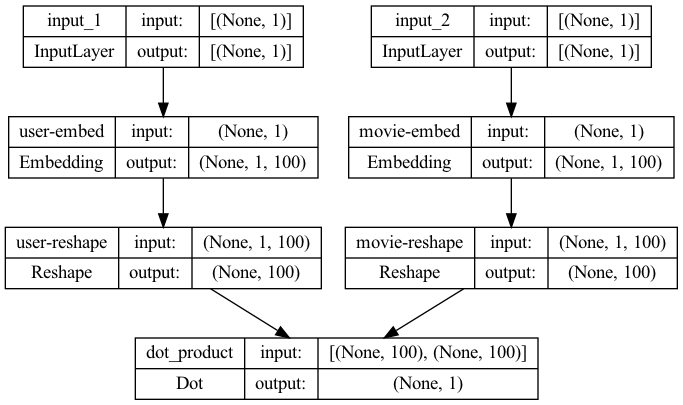

In [15]:

plot_model(model)

In [16]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved with early stopping, tensorboard
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(base_path + '/models/' + 'baseline_weights.h5', save_best_only=True)] #, 
             #tensorboard_callback('baseline_performance')]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, epochs=10, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/10


2023-11-09 14:34:31.105450: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-09 14:34:31.301741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-09 14:37:42.811607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28131/28131 - 198s - loss: 13.8148 - val_loss: 12.5297 - 198s/epoch - 7ms/step
Epoch 2/10
28131/28131 - 197s - loss: 8.3803 - val_loss: 5.2417 - 197s/epoch - 7ms/step
Epoch 3/10
28131/28131 - 198s - loss: 3.8817 - val_loss: 2.9706 - 198s/epoch - 7ms/step
Epoch 4/10
28131/28131 - 202s - loss: 2.4395 - val_loss: 2.0868 - 202s/epoch - 7ms/step
Epoch 5/10
28131/28131 - 197s - loss: 1.8161 - val_loss: 1.6532 - 197s/epoch - 7ms/step
Epoch 6/10
28131/28131 - 198s - loss: 1.4890 - val_loss: 1.4075 - 198s/epoch - 7ms/step
Epoch 7/10
28131/28131 - 198s - loss: 1.2953 - val_loss: 1.2543 - 198s/epoch - 7ms/step
Epoch 8/10
28131/28131 - 201s - loss: 1.1706 - val_loss: 1.1516 - 201s/epoch - 7ms/step
Epoch 9/10
28131/28131 - 197s - loss: 1.0855 - val_loss: 1.0804 - 197s/epoch - 7ms/step
Epoch 10/10
28131/28131 - 198s - loss: 1.0246 - val_loss: 1.0280 - 198s/epoch - 7ms/step


In [17]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 10 = 1.0139


In [18]:
# save history as dataframe
baseline_history_df = pd.DataFrame(history.history)

# save training history
pickle.dump(history.history, open(base_path + '/models/' + 'baseline_history' + '.pickle', "wb"))

# load baseline training data
baseline_history = open(base_path + '/models/' + 'baseline_history' + '.pickle', "rb")

In [19]:

# show baseline training history
baseline_history_df

,loss,val_loss
0,13.814805,12.529721
1,8.380315,5.241728
2,3.881741,2.970576
3,2.439507,2.086783
4,1.816125,1.653219
5,1.489021,1.407462
6,1.295279,1.254293
7,1.170607,1.151559
8,1.085528,1.080389
9,1.024607,1.028018


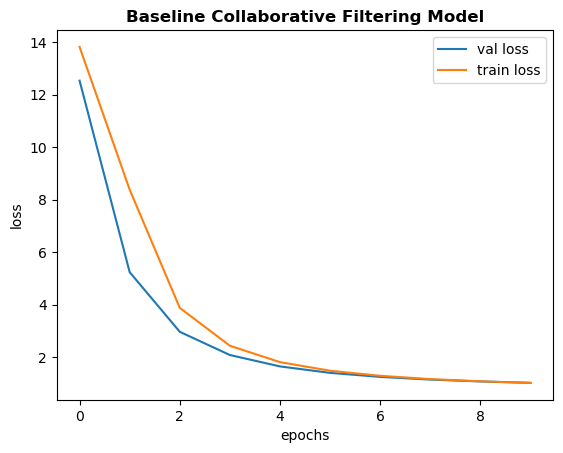

In [20]:

# baseline model loss plot in matplotlib
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(history.history['loss'],  label="train loss")
plt.title('Baseline Collaborative Filtering Model', fontweight='bold')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig(base_path + '/figures/plt/' + 'Baseline Collaborative Filtering Model.jpg',bbox_inches='tight')
plt.show()

In [21]:

# Load weights
model.load_weights(base_path + '/models/' + 'baseline_weights.h5')
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 100)       604000      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 100)       395200      ['input_2[0][0]']                
                                                                                             

In [33]:
TEST_USER=1500

In [34]:
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1499,1500,M,98115,25-34,technician/engineer


In [35]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, user_id, movie_id):
    return model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

In [36]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 8ms/step


,user_id,movie_id,rating,prediction,title,genres
0,1500,1240,5,4.333739,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1,1500,231,5,3.321244,Dumb & Dumber (1994),Comedy
2,1500,2683,5,3.662328,Austin Powers: The Spy Who Shagged Me (1999),Comedy
3,1500,296,5,4.553605,Pulp Fiction (1994),Crime|Drama
4,1500,2858,5,4.721661,American Beauty (1999),Comedy|Drama
5,1500,1136,5,4.634660,Monty Python and the Holy Grail (1974),Comedy
6,1500,1307,5,4.303469,When Harry Met Sally... (1989),Comedy|Romance
7,1500,3911,5,4.307346,Best in Show (2000),Comedy
8,1500,1199,5,4.301246,Brazil (1985),Sci-Fi
9,1500,3897,5,4.504309,Almost Famous (2000),Comedy|Drama


In [37]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


,movie_id,prediction,title,genres
0,527,4.807824,Schindler's List (1993),Drama|War
1,260,4.773744,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,858,4.761878,"Godfather, The (1972)",Action|Crime|Drama
3,1193,4.749418,One Flew Over the Cuckoo's Nest (1975),Drama
4,912,4.746541,Casablanca (1942),Drama|Romance|War
5,1148,4.730125,"Wrong Trousers, The (1993)",Animation|Comedy
6,2019,4.728142,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
7,1198,4.724800,Raiders of the Lost Ark (1981),Action|Adventure
8,745,4.719251,"Close Shave, A (1995)",Animation|Comedy|Thriller
9,922,4.706910,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Film-Noir
